# ECO421 Group Project -- Bank Loan Classification

Anqi Chen, chenan26, aaq.chen@mail.utoronto.ca

Arshvir Singh Bhangoo, bhango10, arshvir.bhangoo@mail.utoronto.ca

Anthony Kutsman, kutsmana, anthony.kutsman@mail.utoronto.ca

## Data import

In [1]:
import pandas as pd
import numpy as np
import qeds
import matplotlib.pyplot as plt

In [2]:
# Read the Loan dataset
df = pd.read_csv("SBAnational.csv", sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
df.isnull().sum()

# Remove ChgOffDate since it has too many missing values
df = df.drop(columns=['ChgOffDate'])

# Drop missing values
df = df.dropna()
df = df.reset_index().drop(columns = 'index')
des = df.describe()
des_transposed = des.T
des_transposed

,count,unique,top,freq
LoanNr_ChkDgt,886240,886240,4288954005,1
Name,886240,769838,SUBWAY,1259
City,886240,32298,LOS ANGELES,11467
State,886240,51,CA,129398
Zip,886240,33501,10001,919
Bank,886240,5788,BANK OF AMERICA NATL ASSOC,86075
BankState,886240,56,CA,116737
NAICS,886240,1311,0,198267
ApprovalDate,886240,9786,7-Jul-93,1120
ApprovalFY,886240,48,2005,76905


## Basic Overview and Cleaning

In [3]:
# Show the counts of two levels of MIS_Status
df.groupby('MIS_Status')['MIS_Status'].count()

MIS_Status
CHGOFF    156041
P I F     730199
Name: MIS_Status, dtype: int64

In [4]:
# Change format of numerical values
df['DisbursementGross'] = df['DisbursementGross'].str.replace(',', '')
df['DisbursementGross'] = df['DisbursementGross'].str.replace('$', '')
df['ChgOffPrinGr'] = df['ChgOffPrinGr'].str.replace(',', '')
df['ChgOffPrinGr'] = df['ChgOffPrinGr'].str.replace('$', '')
df['GrAppv'] = df['GrAppv'].str.replace(',', '')
df['GrAppv'] = df['GrAppv'].str.replace('$', '')
df['SBA_Appv'] = df['SBA_Appv'].str.replace(',', '')
df['SBA_Appv'] = df['SBA_Appv'].str.replace('$', '')
df['ApprovalFY'] = df['ApprovalFY'].str.replace('A', '')

# Set datetime
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate']) 
df['DisbursementDate'] = pd.to_datetime(df['DisbursementDate']) 

# Change object to float
df['ApprovalFY'] = df['ApprovalFY'].astype(float)
df['Term'] = df['Term'].astype(float)
df['NoEmp'] = df['NoEmp'].astype(float)
df['NewExist'] = df['NewExist'].astype(float)
df['CreateJob'] = df['CreateJob'].astype(float)
df['RetainedJob'] = df['RetainedJob'].astype(float)
df['UrbanRural'] = df['UrbanRural'].astype(float)
df['DisbursementGross'] = df['DisbursementGross'].astype(float)
df['ChgOffPrinGr'] = df['ChgOffPrinGr'].astype(float)
df['GrAppv'] = df['GrAppv'].astype(float)
df['SBA_Appv'] = df['SBA_Appv'].astype(float)

In [5]:
# Store numerical level to its original value for RevLineCr
revolvingline = df.groupby('RevLineCr').apply(lambda x: list()).to_dict()

i = 1
for value in revolvingline:
    revolvingline[value] = i
    i += 1

revolvingline

{',': 1,
 '-': 2,
 '.': 3,
 '0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '7': 10,
 'A': 11,
 'C': 12,
 'N': 13,
 'Q': 14,
 'R': 15,
 'T': 16,
 'Y': 17,
 '`': 18}

In [6]:
# Store numerical level to its original value for LowDoc
loanprogram = df.groupby('LowDoc').apply(lambda x: list()).to_dict()

i = 1
for value in loanprogram:
    loanprogram[value] = i
    i += 1

loanprogram

{'0': 1, '1': 2, 'A': 3, 'C': 4, 'N': 5, 'R': 6, 'S': 7, 'Y': 8}

In [7]:
# Turn RevLineCr into numerical variables
df['RevLineCr'] = df['RevLineCr'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df['RevLineCr'] = df['RevLineCr'].astype(float)

# Turn LowDoc into numerical variables
df['LowDoc'] = df['LowDoc'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df['LowDoc'] = df['LowDoc'].astype(float)

In [8]:
# In order to split the dataset into 3 groups - calculating quatiles - 1st,2nd,3rd 
df.SBA_Appv.quantile([0.33,0.66,1])

0.33      26640.0
0.66     121635.0
1.00    4500000.0
Name: SBA_Appv, dtype: float64

In [9]:
# Creating a new variable with 3 levels of SBA loan amount
df['SBA_amount_level'] = 0

df.loc[(df['SBA_Appv'] <= 26640.0), 'SBA_amount_level'] = 1
df.loc[(df['SBA_Appv'] > 26640.0) & (df['SBA_Appv'] <= 121635.0), 'SBA_amount_level'] = 2
df.loc[(df['SBA_Appv'] > 121635.0) & (df['SBA_Appv'] <= 4500000.0), 'SBA_amount_level'] = 3

In [10]:
# Choose a list of potential predictors
col_name = ['ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
            'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 
            'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_amount_level']

# Display summary statistics
des2 = df[col_name].describe()
des_transposed2 = des2.T
des_transposed2

,count,mean,std,min,25%,50%,75%,max
ApprovalFY,886240.0,2001.149622,5.880586,1968.0,1997.0,2002.0,2006.0,2014.0
Term,886240.0,110.954647,78.990583,0.0,60.0,84.0,120.0,569.0
NoEmp,886240.0,11.420650,74.187995,0.0,2.0,4.0,10.0,9999.0
NewExist,886240.0,1.279900,0.451509,0.0,1.0,1.0,2.0,2.0
CreateJob,886240.0,8.463092,237.301746,0.0,0.0,0.0,1.0,8800.0
RetainedJob,886240.0,10.842406,237.739546,0.0,0.0,1.0,4.0,9500.0
UrbanRural,886240.0,0.759725,0.646074,0.0,0.0,1.0,1.0,2.0
RevLineCr,886240.0,10.332192,4.947374,0.0,3.0,12.0,12.0,17.0
LowDoc,886240.0,4.359118,0.997451,0.0,4.0,4.0,4.0,7.0
DisbursementGross,886240.0,202141.902469,287938.000625,4000.0,42837.0,100000.0,240000.0,11446325.0


## Data Visualization

Text(0, 0.5, 'Number of businesses')

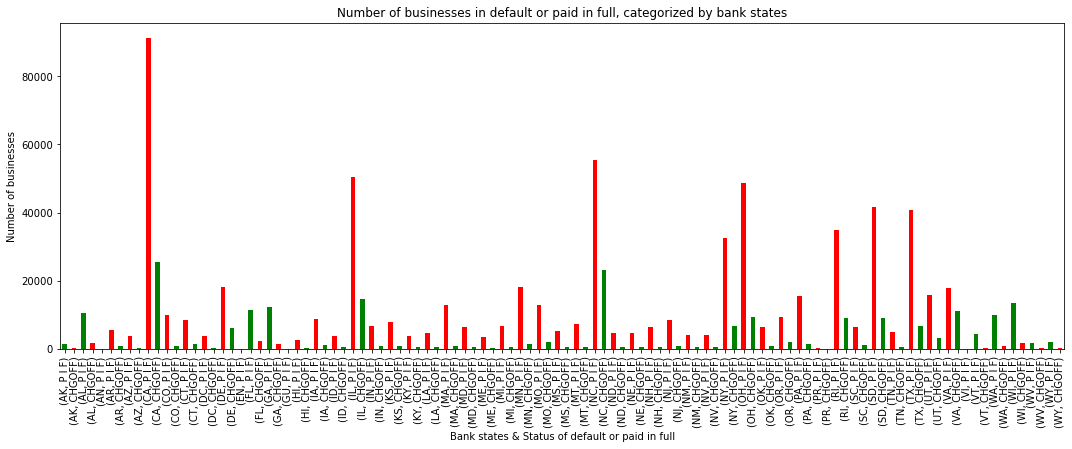

In [11]:
# A bar plot of counts of MIS_Status groupby BankStates
df.groupby(['BankState'])['MIS_Status'].value_counts().plot(kind='bar', figsize=(18, 6), color=['g', 'r'])
plt.title("Number of businesses in default or paid in full, categorized by bank states")
plt.xlabel("Bank states & Status of default or paid in full")
plt.ylabel("Number of businesses")

Text(0, 0.5, 'Number of businesses')

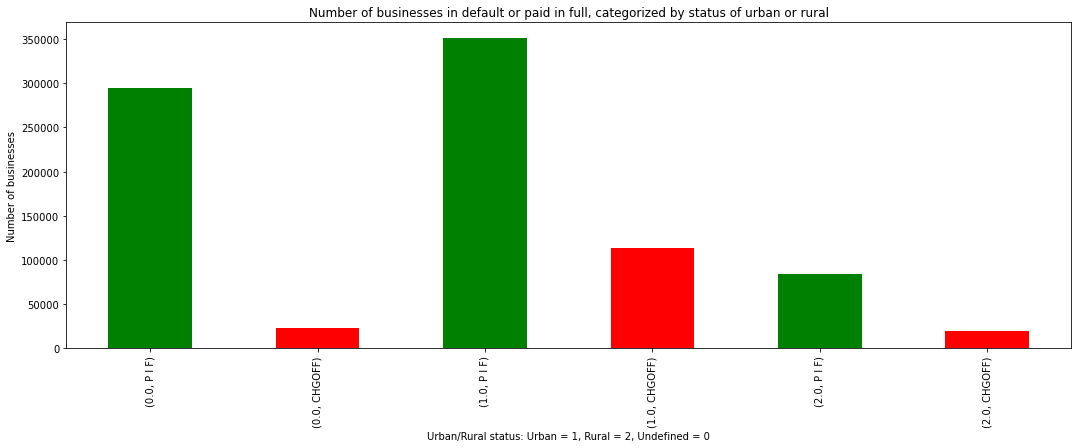

In [12]:
# A bar plot of counts of MIS_Status groupby UrbanRural
df.groupby(['UrbanRural'])['MIS_Status'].value_counts().plot(kind='bar', figsize=(18, 6), color=['g', 'r'])
plt.title("Number of businesses in default or paid in full, categorized by status of urban or rural")
plt.xlabel("Urban/Rural status: Urban = 1, Rural = 2, Undefined = 0")
plt.ylabel("Number of businesses")

Text(0, 0.5, 'Number of businesses')

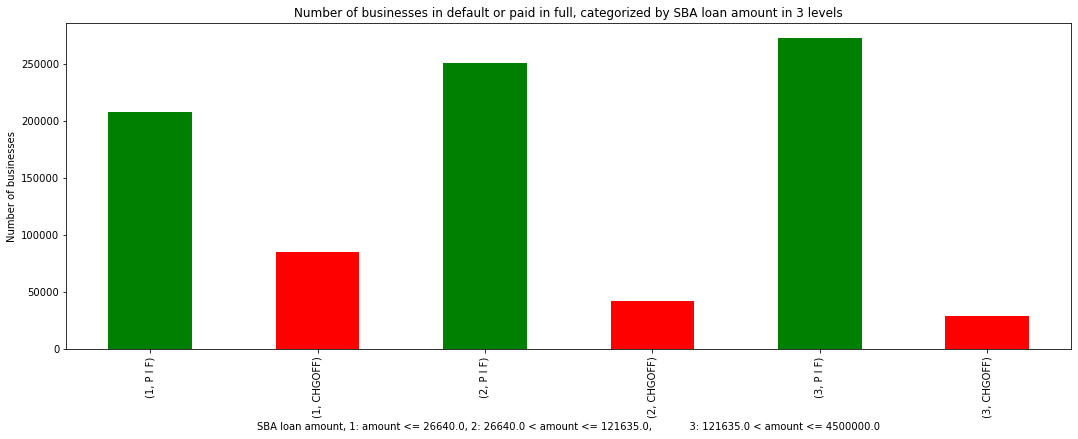

In [13]:
# A bar plot of counts of MIS_Status groupby SBA_amount_level
df.groupby(['SBA_amount_level'])['MIS_Status'].value_counts().plot(kind='bar', figsize=(18, 6), color=['g', 'r'])
plt.title("Number of businesses in default or paid in full, categorized by SBA loan amount in 3 levels")
plt.xlabel("SBA loan amount, 1: amount <= 26640.0, 2: 26640.0 < amount <= 121635.0, \
           3: 121635.0 < amount <= 4500000.0")
plt.ylabel("Number of businesses")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4e9ff0580>]],
      dtype=object)

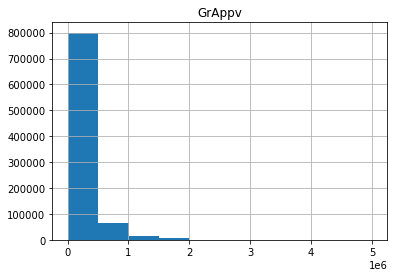

In [14]:
# A histogram of GrAppv
df.hist(column = 'GrAppv', bins = 10)

In [15]:
# Represent the two levels as integers
df['MIS_Status'] = df.MIS_Status.replace({"P I F": 0, "CHGOFF": 1})

# calculate default rate
by_state = df.groupby(['State'])
state_def = df.groupby(['State'])['MIS_Status']

total = {}
for state in df['State'].unique():
    total[state] = state_def.get_group(state).sum() / by_state.get_group(state)['Zip'].count()

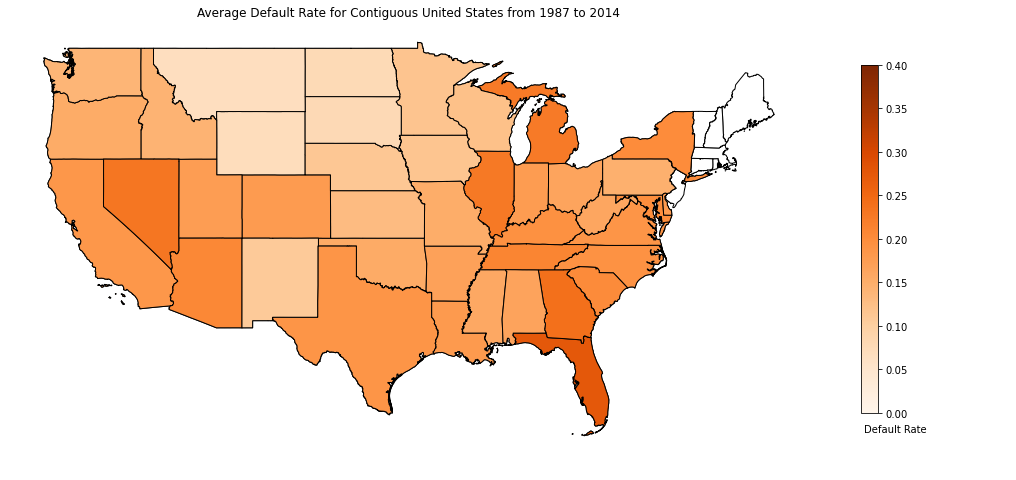

In [16]:
import geopandas as gpd
import pgeocode
from shapely.geometry import Point

# use zip code to have latitude and longitude for observations
nomi1 = pgeocode.Nominatim("us")
df_map = df[['City', 'State', 'Zip']].copy().drop_duplicates('State')
df_map = df_map[df_map['Zip'].map(len) > 4].reset_index().drop(columns = 'index')
df_loc = df_map["Zip"].apply(lambda x:nomi1.query_postal_code(x))
df_loc = df_loc.drop(columns = ['community_name', 'community_code'])
df_loc = df_loc.dropna()

df_map = pd.concat([df_map, df_loc], axis="columns")
df_map = df_map.dropna(subset = ["latitude", "longitude"])
df_map = df_map.loc[:,~df_map.columns.duplicated()]

df_map['Default rate'] = 0

# for index, row in df_map.iterrows():
for state in total:
    df_map.loc[df_map['State'] == state, 'Default rate'] = total[state]

# transform to point and apply gdf
df_map["Coordinates"] = list(zip(df_map.longitude, df_map.latitude))
df_map["Coordinates"] = df_map["Coordinates"].apply(Point)

# import US map dataset and combine with loan dataset
us_map = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
us_map = us_map.set_index(['NAME'])
us_map = us_map.drop(['Puerto Rico', 'American Samoa', \
             'Guam', 'Commonwealth of the Northern Mariana Islands', \
                      'United States Virgin Islands', 'Alaska', 'Hawaii'], axis=0)

combine = df_map.merge(us_map, left_on="State", right_on="STUSPS", how="inner")

# Change it into a Geo Data Frame
combine = gpd.GeoDataFrame(combine, geometry = "geometry")

# create map of the US
fig, gax = plt.subplots(figsize=(18,8))
us_map.plot(ax = gax, edgecolor='black',color='white')

# Plot the map
combine.plot(
    ax=gax, edgecolor='black', column='Default rate', 
    legend=True, legend_kwds={'shrink': 0.8}, cmap= "Oranges",
    vmin=0, vmax=0.4)

gax.annotate('Default Rate',xy=(0.85, 0.1),  xycoords='figure fraction')
gax.set_title('Average Default Rate for Contiguous United States from 1987 to 2014')
plt.axis('off')
plt.show()  

## Construct Classifiers

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn import metrics

In [18]:
df_class = df[col_name]

In [19]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_class, df['MIS_Status'], test_size=0.3, random_state = 0)

### Logistic Classifier

training: 0.9814884068810771
test: 0.9813820184148764
AUC score: 0.9935361370870718


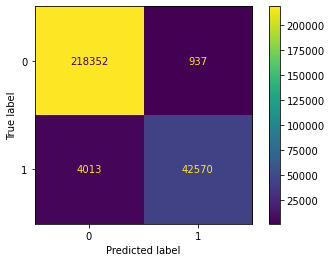

In [20]:
# Logistic Classifier
lr = LogisticRegression(max_iter = 10000).fit(X_train,y_train)
y_pred = lr.predict(X_test)

# print training and test accuracy rate
print("training:",lr.score(X_train,y_train))
print("test:",lr.score(X_test,y_test))

# record FP, recall rate
accuracy, AUC = [], []
accuracy.append(lr.score(X_test,y_test))

# plot confusion matrix
graph = plot_confusion_matrix(lr, X_test, y_test)  

# AUC score
auc_logit = roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1])
print("AUC score:", auc_logit)
AUC.append(auc_logit)

### Naive Bayes

training: 0.961632450416527
test: 0.9617372269362701
AUC score: 0.9901292378835354


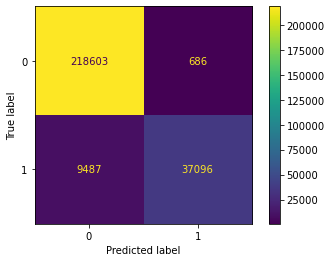

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# print training and test accuracy rate
print("training:",gnb.score(X_train,y_train))
print("test:",gnb.score(X_test,y_test))

# record FP, recall rate
accuracy.append(gnb.score(X_test,y_test))

# AUC score
auc_nb = roc_auc_score(y_train, gnb.predict_proba(X_train)[:, 1])
print("AUC score:", auc_nb)
AUC.append(auc_nb)

# plot confusion matrix
graph = plot_confusion_matrix(gnb, X_test, y_test)

### Decision Tree

training: 0.9999935522141696
test: 0.9881860444123488
AUC score:  0.9780608466692786


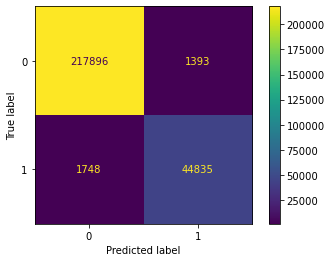

In [22]:
# Decision Tree Classifier
dt = tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

y_pred = dt.predict(X_test)

# print training and test accuracy rate
print("training:", dt.score(X_train,y_train))
print("test:", dt.score(X_test,y_test))

# record FP, recall rate
accuracy.append(dt.score(X_test,y_test))

# plot confusion matrix
graph = plot_confusion_matrix(dt, X_test, y_test)

# AUC score
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
print("AUC score: ", auc_dt)
AUC.append(auc_dt)

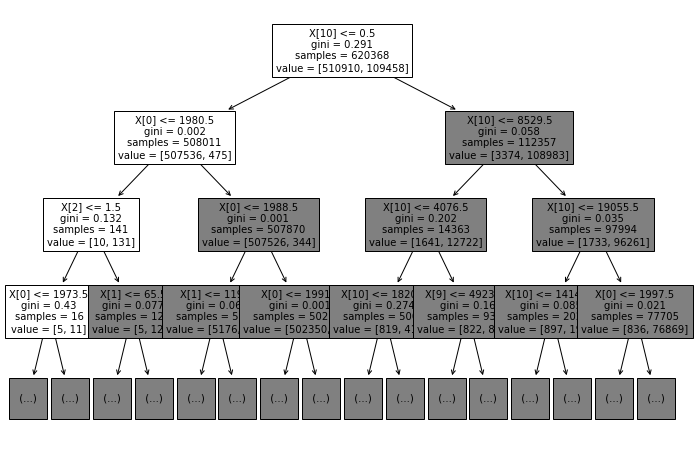

In [23]:
#plot the decision tree
plt.figure(figsize=(12,8))
a = tree.plot_tree(dt,fontsize=10, max_depth = 3) 

### Random Forest

training: 0.9937972300312072
test: 0.993782722513089
AUC score:  0.996042507490823


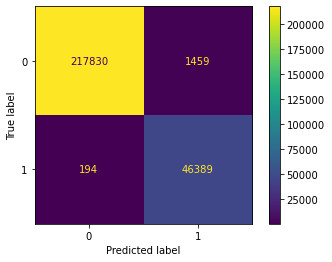

In [24]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0, max_depth = 5, min_samples_leaf = 4)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

# print training and test accuracy rate
print("training:", rf.score(X_train,y_train))
print("test:", rf.score(X_test,y_test))

# record FP, recall rate
accuracy.append(rf.score(X_test,y_test))

# plot confusion matrix
graph = plot_confusion_matrix(rf, X_test, y_test)

# AUC score
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print("AUC score: ", auc_rf)
AUC.append(auc_rf)

## Compare the results

In [25]:
pd.DataFrame({"Accuracy":accuracy, "AUC score":AUC},
            index = ["Logistic","Naive Bayes", "Decision Tree", "Random Forest"])

,Accuracy,AUC score
Logistic,0.981382,0.993536
Naive Bayes,0.961737,0.990129
Decision Tree,0.988186,0.978061
Random Forest,0.993783,0.996043


## Top characteristics of businesses that default

Feature: 0, Score: 0.72068
Feature: 1, Score: 0.18591
Feature: 2, Score: 0.03416
Feature: 3, Score: 0.01224
Feature: 4, Score: 0.01121
Feature: 5, Score: 0.01070
Feature: 6, Score: 0.00749
Feature: 7, Score: 0.00741
Feature: 8, Score: 0.00340
Feature: 9, Score: 0.00285
Index(['Term', 'Name', 'LoanNr_ChkDgt', 'NewExist', 'BankState', 'Bank',
       'NoEmp', 'CreateJob', 'ApprovalFY', 'NAICS'],
      dtype='object')


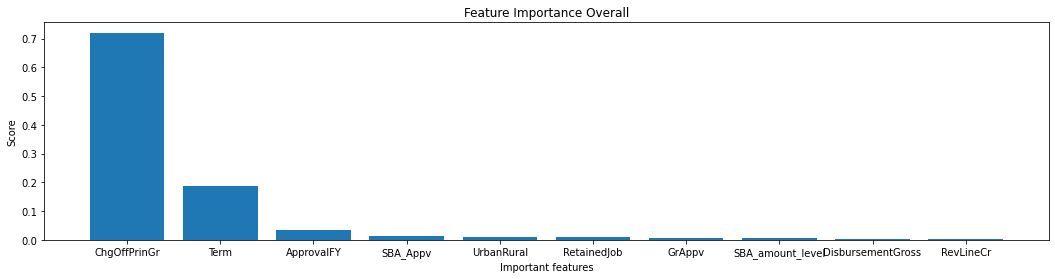

In [26]:
# get top 10 important features
importance = rf.feature_importances_
ind = np.argsort(-importance)[:10]

# summarize feature importance
for i,v in enumerate(importance[ind]):
    print('Feature: %0d, Score: %.5f' % (i,v))
print(df.columns[ind])

# plot feature importance
plt.figure(figsize=(18,4))
plt.bar(df_class.columns[ind], importance[ind])
plt.title("Feature Importance Overall")
plt.xlabel("Important features")
plt.ylabel("Score")
plt.show()

In [27]:
print('Correlation between Charged off amount and loan default is:', 
       df_class['ChgOffPrinGr'].corr(df['MIS_Status']))

print('Correlation between Loan term and loan default is:', 
       df_class['Term'].corr(df['MIS_Status']))

print('Correlation between Fiscal year of issue and loan default is:', 
       df_class['ApprovalFY'].corr(df['MIS_Status']))

Correlation between Charged off amount and loan default is: 0.4445787204597517
Correlation between Loan term and loan default is: -0.31579773210003476
Correlation between Fiscal year of issue and loan default is: 0.20527001695822408


## Top characteristics of businesses that default based on SBA loan amount

In [28]:
# Create seperate dataset with each loan level
df_1 = df[df['SBA_Appv'] <= 26640.0]
df_2 = df[df['SBA_Appv'] > 26640.0][df['SBA_Appv'] <= 121635.0]
df_3 = df[df['SBA_Appv'] > 121635.0][df['SBA_Appv'] <= 4500000.0]

<ipython-input-28-82fc941db558>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2 = df[df['SBA_Appv'] > 26640.0][df['SBA_Appv'] <= 121635.0]
<ipython-input-28-82fc941db558>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_3 = df[df['SBA_Appv'] > 121635.0][df['SBA_Appv'] <= 4500000.0]


Feature: 0, Score: 0.69973
Feature: 1, Score: 0.22869
Feature: 2, Score: 0.03162
Feature: 3, Score: 0.01283
Feature: 4, Score: 0.00738
Feature: 5, Score: 0.00514
Feature: 6, Score: 0.00498
Feature: 7, Score: 0.00291
Feature: 8, Score: 0.00268
Feature: 9, Score: 0.00204
Index(['Term', 'Name', 'LoanNr_ChkDgt', 'Bank', 'BankState', 'NAICS',
       'ApprovalFY', 'ApprovalDate', 'NoEmp', 'Zip'],
      dtype='object')


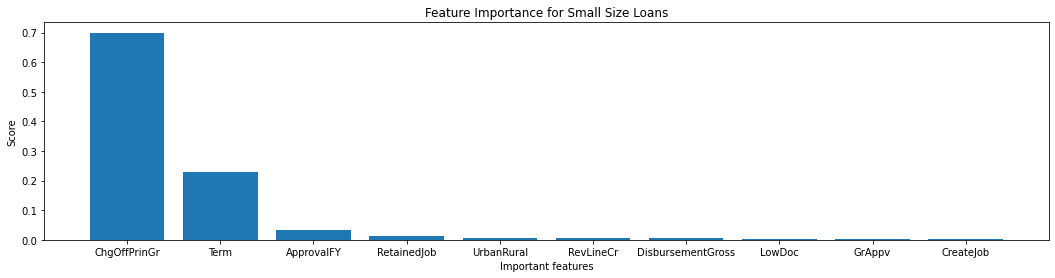

In [29]:
# Create random forest classifier for model 1
df_class_1 = df_1[col_name]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_class_1, df_1['MIS_Status'], 
                                                    test_size=0.3, random_state = 0)

rf1 = RandomForestClassifier(random_state = 0, max_depth = 5, min_samples_leaf = 4)
rf1.fit(X_train_1,y_train_1)
y_pred = rf1.predict(X_test_1)

# get top 10 important features
importance = rf1.feature_importances_
ind = np.argsort(-importance)[:10]

# summarize feature importance
for i,v in enumerate(importance[ind]):
    print('Feature: %0d, Score: %.5f' % (i,v))
print(df.columns[ind])

# plot feature importance
plt.figure(figsize=(18,4))
plt.bar(df_class_1.columns[ind], importance[ind])
plt.title("Feature Importance for Small Size Loans")
plt.xlabel("Important features")
plt.ylabel("Score")
plt.show()

Feature: 0, Score: 0.72988
Feature: 1, Score: 0.19524
Feature: 2, Score: 0.03263
Feature: 3, Score: 0.01250
Feature: 4, Score: 0.01054
Feature: 5, Score: 0.00598
Feature: 6, Score: 0.00419
Feature: 7, Score: 0.00213
Feature: 8, Score: 0.00209
Feature: 9, Score: 0.00153
Index(['Term', 'Name', 'LoanNr_ChkDgt', 'BankState', 'Bank', 'NAICS',
       'NewExist', 'NoEmp', 'City', 'State'],
      dtype='object')


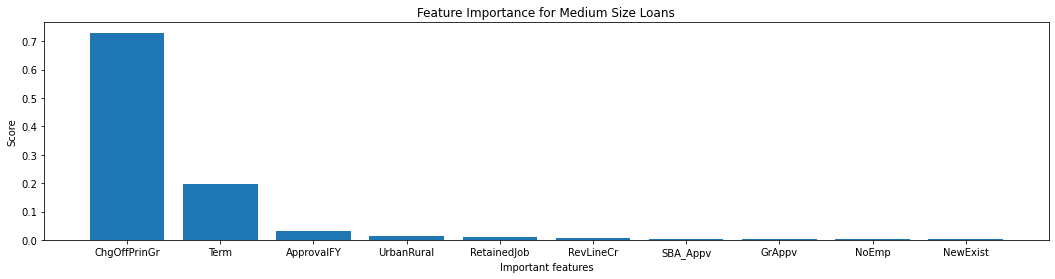

In [30]:
# Create random forest classifier for model 2
df_class_2 = df_2[col_name]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_class_2, df_2['MIS_Status'], 
                                                    test_size=0.3, random_state = 0)

rf2 = RandomForestClassifier(random_state = 0, max_depth = 5, min_samples_leaf = 4)
rf2.fit(X_train_2,y_train_2)
y_pred = rf2.predict(X_test_2)

# get top 10 important features
importance = rf2.feature_importances_
ind = np.argsort(-importance)[:10]

# summarize feature importance
for i,v in enumerate(importance[ind]):
    print('Feature: %0d, Score: %.5f' % (i,v))
print(df.columns[ind])

# plot feature importance
plt.figure(figsize=(18,4))
plt.bar(df_class_2.columns[ind], importance[ind])
plt.title("Feature Importance for Medium Size Loans")
plt.xlabel("Important features")
plt.ylabel("Score")
plt.show()

Feature: 0, Score: 0.82825
Feature: 1, Score: 0.10502
Feature: 2, Score: 0.03341
Feature: 3, Score: 0.00787
Feature: 4, Score: 0.00684
Feature: 5, Score: 0.00548
Feature: 6, Score: 0.00458
Feature: 7, Score: 0.00297
Feature: 8, Score: 0.00197
Feature: 9, Score: 0.00132
Index(['Term', 'Name', 'LoanNr_ChkDgt', 'NAICS', 'State', 'BankState', 'City',
       'Zip', 'Bank', 'NoEmp'],
      dtype='object')


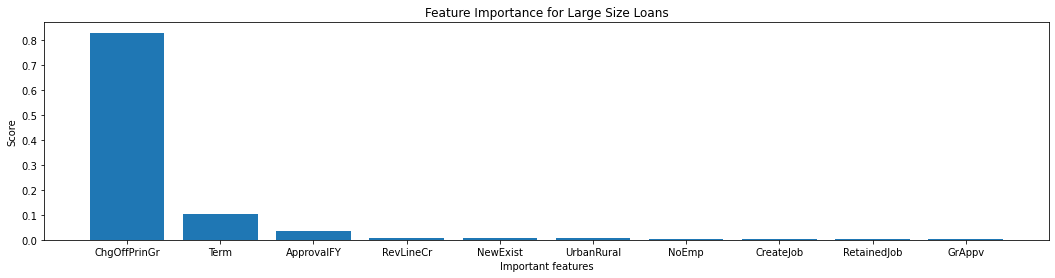

In [31]:
# Create random forest classifier for model 3
df_class_3 = df_3[col_name]
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_class_3, df_3['MIS_Status'], 
                                                    test_size=0.3, random_state = 0)

rf3 = RandomForestClassifier(random_state = 0, max_depth = 5, min_samples_leaf = 4)
rf3.fit(X_train_3,y_train_3)
y_pred = rf3.predict(X_test_3)

# get top 10 important features
importance = rf3.feature_importances_
ind = np.argsort(-importance)[:10]

# summarize feature importance
for i,v in enumerate(importance[ind]):
    print('Feature: %0d, Score: %.5f' % (i,v))
print(df.columns[ind])

# plot feature importance
plt.figure(figsize=(18,4))
plt.bar(df_class_3.columns[ind], importance[ind])
plt.title("Feature Importance for Large Size Loans")
plt.xlabel("Important features")
plt.ylabel("Score")
plt.show()